# A day in the life of the SGP
Date selected to match Mariko Oue's Paper:
https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2016GL070776

In [146]:
import xarray
import numpy as np
from matplotlib import pyplot as plt
import netCDF4

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from metpy.calc import get_wind_components, lcl, dry_lapse, parcel_profile
from metpy.plots import SkewT, Hodograph
from metpy.units import units, concatenate

import matplotlib.gridspec as gridspec

from pyart.graph.cm_colorblind import HomeyerRainbow

%matplotlib inline

# Sounding Data

In [49]:
#Sounding data 
sounding = netCDF4.Dataset('../data/sgpsondewnpnC1.b1.20150609.173100.cdf')

In [50]:
#Lets see what is in the data
print(sounding.variables.keys())

odict_keys(['base_time', 'time_offset', 'time', 'qc_time', 'pres', 'qc_pres', 'tdry', 'qc_tdry', 'dp', 'qc_dp', 'wspd', 'qc_wspd', 'deg', 'qc_deg', 'rh', 'qc_rh', 'u_wind', 'qc_u_wind', 'v_wind', 'qc_v_wind', 'wstat', 'asc', 'qc_asc', 'lat', 'lon', 'alt'])


In [51]:
#Extract the variables 
T = sounding.variables['tdry'][:]
Td = sounding.variables['dp'][:]
p = sounding.variables['pres'][:]
height = sounding.variables['alt'][:]

u = sounding.variables['u_wind'][:]
v = sounding.variables['v_wind'][:]

#Use MetPy's Unites to add units
p = p * units.hPa
T = T * units.degC
Td = Td * units.degC
u = u * units.m/units.s
v = v * units.m/units.s


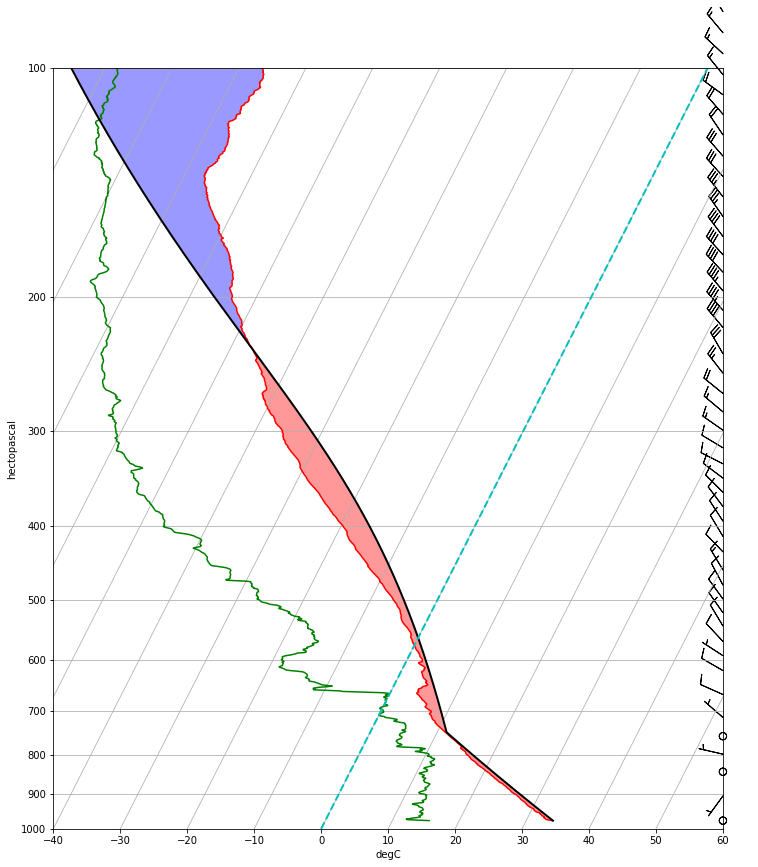

In [52]:
#Change figure size.. Save the figure size so we can switch back later
old_params = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (12, 14)


#Create a skewT plot
skew = SkewT()

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::40], u[::40], v[::40]) #We thin the wind barbs.. only every 40th
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)


# Calculate full parcel profile and add to plot as black line
prof = parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Example of coloring area between profiles
skew.ax.fill_betweenx(p, T, prof, where=T>=prof, facecolor='blue', alpha=0.4)
skew.ax.fill_betweenx(p, T, prof, where=T<prof, facecolor='red', alpha=0.4)

# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

#change back to old figure size
plt.rcParams['figure.figsize'] = old_params


# LWP from MWR

In [53]:
#Lets play with X-Array for the MWR data
mwrret = xarray.open_dataset('../data/sgpmwrret1liljclouC1.c1.20150609.000039.cdf')

In [54]:
#What is there?
mwrret.info()

xarray.Dataset {
dimensions:
	nlevels = 54 ;
	nvbias = 100 ;
	time = 3332 ;

variables:
	datetime64[ns] base_time() ;
		base_time:string = 9-Jun-2015, 00:00:00 GMT ;
		base_time:long_name = Base time in Epoch ;
	datetime64[ns] time_offset(time) ;
		time_offset:long_name = Time offset from base_time ;
	datetime64[ns] time(time) ;
		time:long_name = Time offset from midnight ;
	int32 qc_time(time) ;
		qc_time:long_name = Quality check results on field: Time offset from midnight ;
		qc_time:units = unitless ;
		qc_time:description = This field contains bit packed values which should be interpreted as listed. No bits set (zero) represents good data. ;
		qc_time:bit_1_description = Delta time between current and previous samples is zero. ;
		qc_time:bit_1_assessment = Indeterminate ;
		qc_time:bit_2_description = Delta time between current and previous samples is less than the delta_t_lower_limit field attribute. ;
		qc_time:bit_2_assessment = Indeterminate ;
		qc_time:bit_3_description = D

In [55]:
#Lets look at LWP

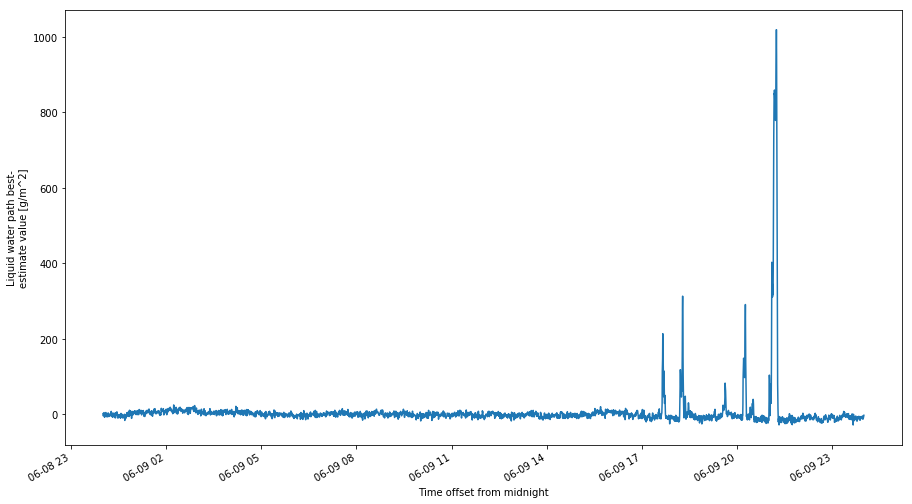

In [56]:
my_fig = plt.figure(figsize=[15,8])
mwrret.be_lwp.plot()

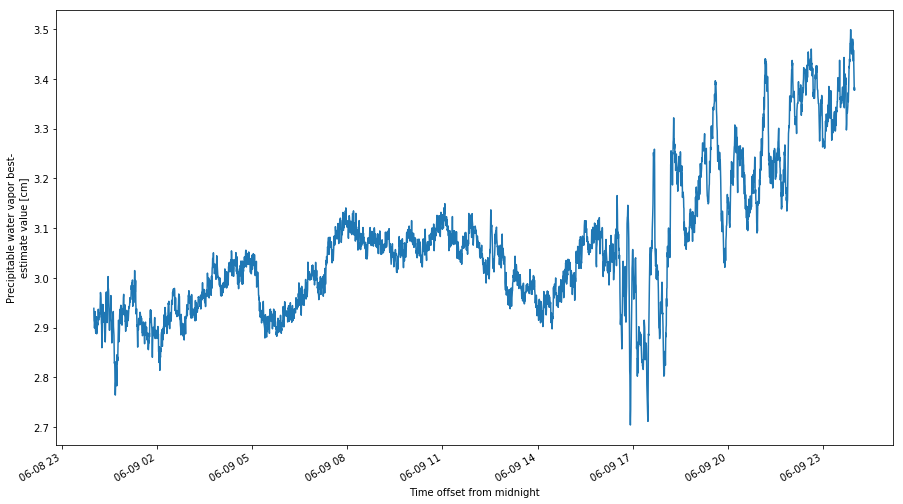

In [57]:
my_fig = plt.figure(figsize=[15,8])
mwrret.be_pwv.plot()

In [58]:
# Well that was easy! Lets do some stats

Mean PWV  3.0680782794952393 cm
Stdev PWV  0.14181797206401825 cm


(array([ 11.,  68., 567., 734., 967., 311., 281., 161., 172.,  60.]),
 array([2.70411825, 2.78359754, 2.86307683, 2.94255612, 3.02203541,
        3.1015147 , 3.18099399, 3.26047328, 3.33995256, 3.41943185,
        3.49891114]),
 <a list of 10 Patch objects>)

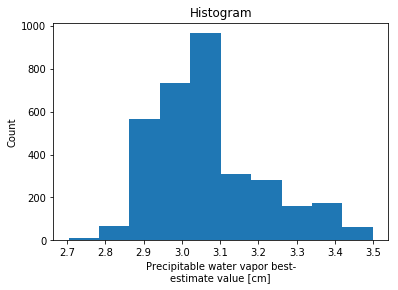

In [59]:
precip_water = mwrret.be_pwv
print("Mean PWV ", mwrret.be_pwv.mean().values, mwrret.be_pwv.units)
print("Stdev PWV ", mwrret.be_pwv.std().values, mwrret.be_pwv.units)
mwrret.be_pwv.plot.hist()

In [60]:
#Lets play with X-Array for the MWR data MULTI-DAY!
mwrret_md = xarray.open_mfdataset('../data/sgpmwrret1liljclouC1.c1.*')

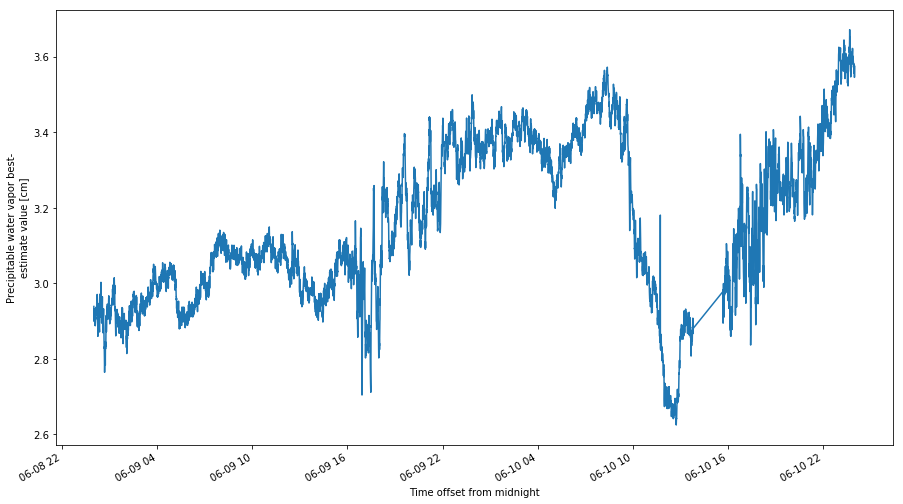

In [61]:
my_fig = plt.figure(figsize=[15,8])
mwrret_md.be_pwv.plot()

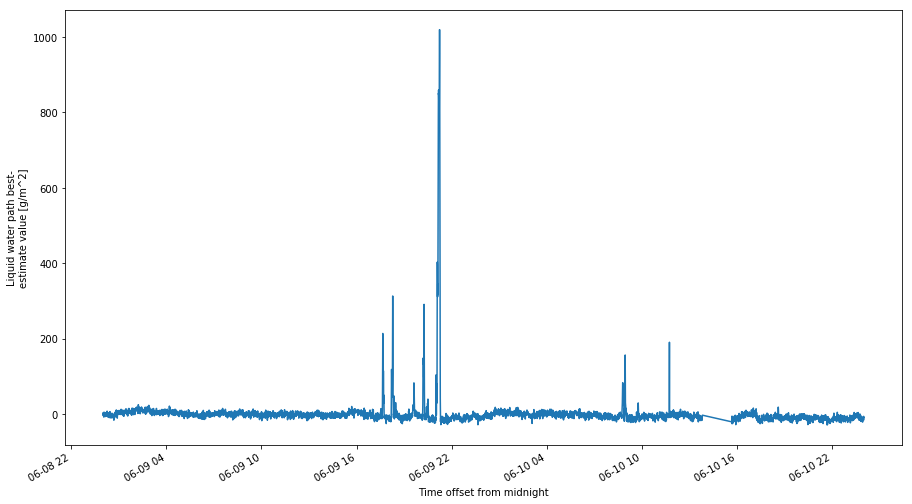

In [62]:
my_fig = plt.figure(figsize=[15,8])
mwrret_md.be_lwp.plot()

# Vertical winds from LIDAR

In [63]:
#Lets play with X-Array for the Lidar Vert data
dl_fpt = xarray.open_mfdataset('../data/sgpdlfptC1.b1.*')

In [64]:
#What is there?
dl_fpt.info()

xarray.Dataset {
dimensions:
	range = 320 ;
	time = 152926 ;

variables:
	float32 range(range) ;
		range:long_name = Distance from Lidar to center of range gate ;
		range:units = m ;
	datetime64[ns] base_time(time) ;
		base_time:long_name = Base time in Epoch ;
	datetime64[ns] time_offset(time) ;
		time_offset:long_name = Time offset from base_time ;
	datetime64[ns] time(time) ;
		time:long_name = Time offset from midnight ;
	int32 qc_time(time) ;
		qc_time:long_name = Quality check results on field: Time offset from midnight ;
		qc_time:units = unitless ;
		qc_time:description = This field contains bit packed values which should be interpreted as listed. No bits set (zero) represents good data. ;
		qc_time:bit_1_description = Delta time between current and previous samples is zero. ;
		qc_time:bit_1_assessment = Indeterminate ;
		qc_time:bit_2_description = Delta time between current and previous samples is less than the delta_t_lower_limit field attribute. ;
		qc_time:bit_2_assessmen

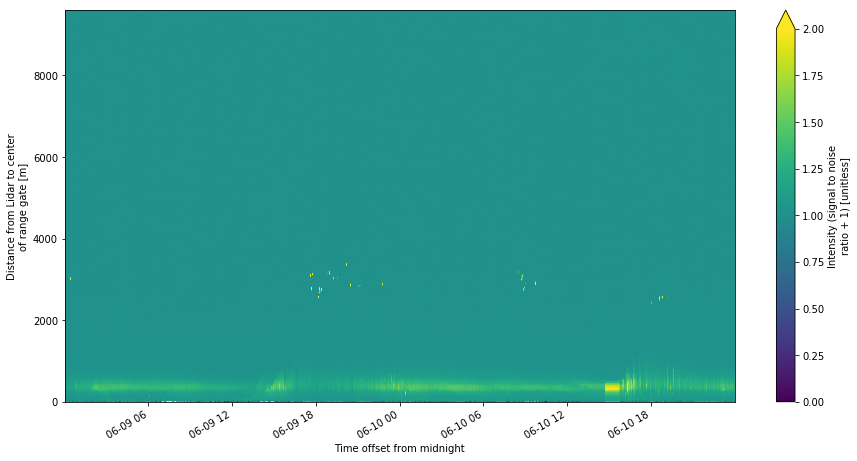

In [93]:
#This takes some time! Lots of data
my_fig = plt.figure(figsize=[15,8])
#Transpose to get time height.. 
dl_fpt.intensity.transpose().plot.pcolormesh(vmax=2., vmin=0)

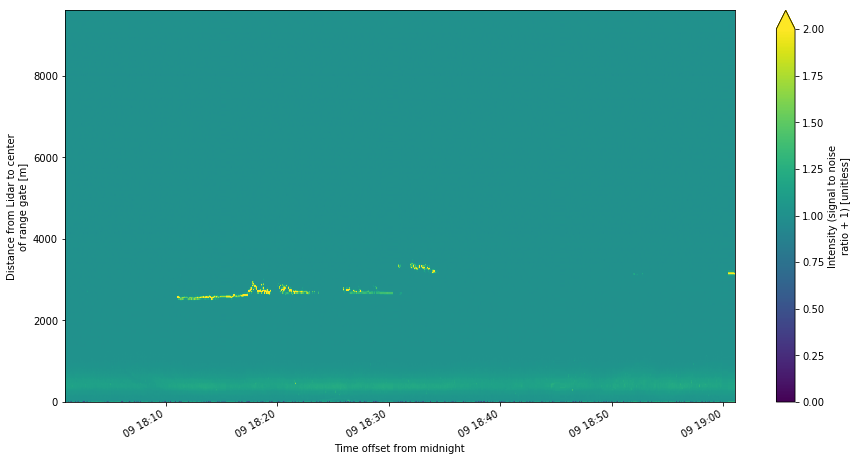

In [95]:
my_fig = plt.figure(figsize=[15,8])
#Transpose to get time height..  da.sel(time=slice('2000-01-01', '2000-01-02'))
sm_dataset = dl_fpt.sel(time=slice('2015-06-09 18:00', '2015-06-09 19:00'))
sm_dataset.intensity.transpose().plot.pcolormesh(vmax=2., vmin=0)


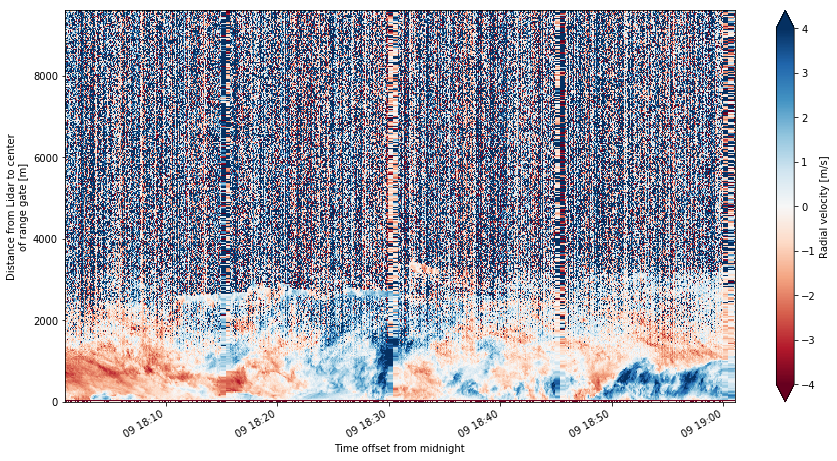

In [124]:
my_fig = plt.figure(figsize=[15,8])
#Transpose to get time height..  da.sel(time=slice('2000-01-01', '2000-01-02'))
sm_dataset = dl_fpt.sel(time=slice('2015-06-09 18:00', '2015-06-09 19:00'))
sm_dataset.radial_velocity.transpose().plot.pcolormesh(vmin=-4, vmax=4, cmap=plt.cm.RdBu)


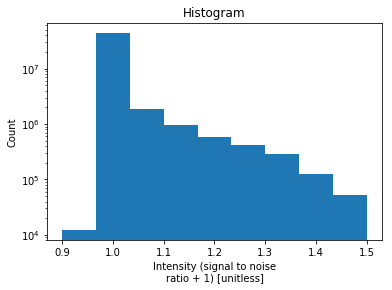

In [118]:
intens = dl_fpt.intensity
intens.plot.hist(bins=np.linspace(0.9, 1.6, 10))
plt.gca().set_yscale('log')

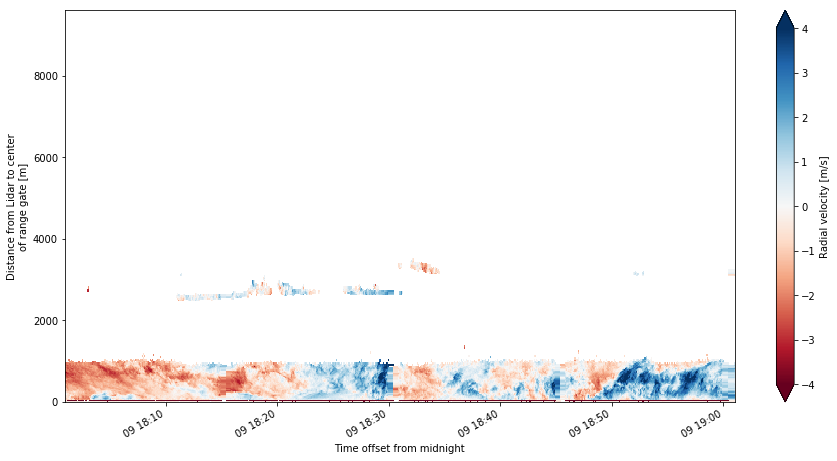

In [125]:
intens = dl_fpt.intensity
my_fig = plt.figure(figsize=[15,8])
#Transpose to get time height..  da.sel(time=slice('2000-01-01', '2000-01-02'))
sm_dataset = dl_fpt.where(intens > 1.03).sel(time=slice('2015-06-09 18:00', '2015-06-09 19:00'))
sm_dataset.radial_velocity.transpose().plot.pcolormesh(vmin=-4, vmax=4, cmap=plt.cm.RdBu)


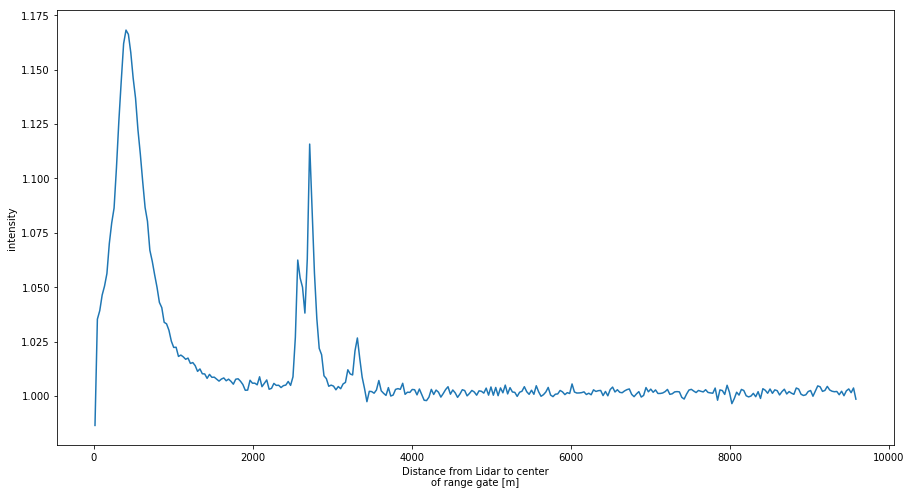

In [100]:
#Axis averaging! 
my_fig = plt.figure(figsize=[15,8])

sm_dataset.intensity.mean(dim='time').plot()

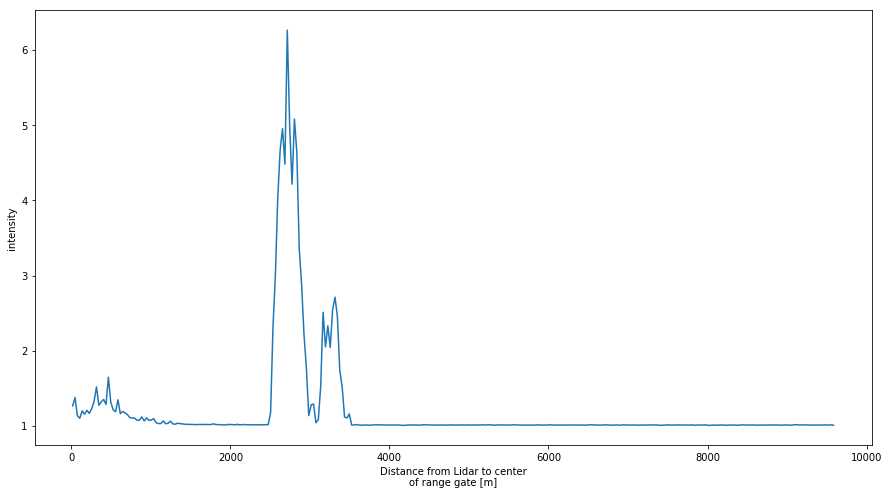

In [103]:
#Axis averaging! 
my_fig = plt.figure(figsize=[15,8])

sm_dataset.intensity.max(dim='time').plot()

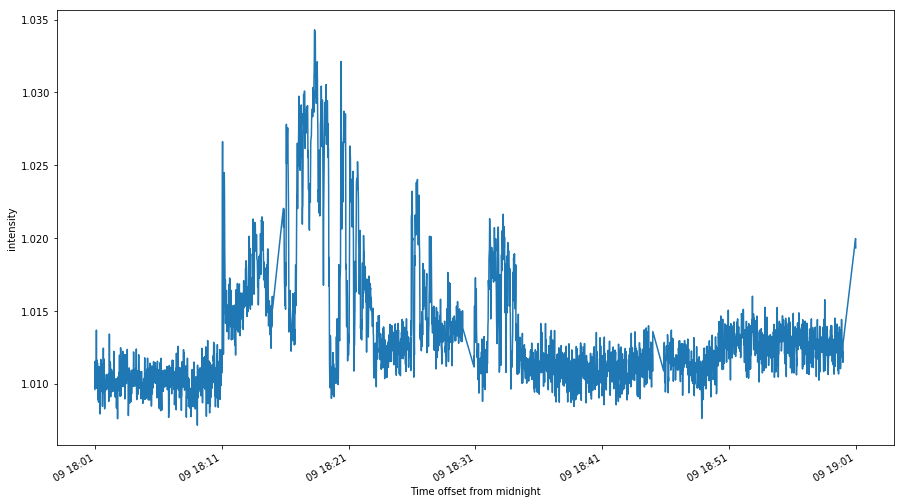

In [102]:
#Axis averaging! 
my_fig = plt.figure(figsize=[15,8])

sm_dataset.intensity.mean(dim='range').plot()

# Wind direction from LIDAR

In [104]:
lwd_data = xarray.open_dataset('../data/sgpdlprofwind4newsC1.c1.20150609.000034.nc')

In [105]:
lwd_data.info()

xarray.Dataset {
dimensions:
	bound = 2 ;
	height = 164 ;
	time = 96 ;

variables:
	datetime64[ns] base_time() ;
		base_time:string = 2015-06-09 00:00:00 0:00 ;
		base_time:long_name = Base time in Epoch ;
		base_time:ancillary_variables = time_offset ;
	datetime64[ns] time_offset(time) ;
		time_offset:long_name = Time offset from base_time ;
		time_offset:ancillary_variables = base_time ;
	datetime64[ns] time(time) ;
		time:long_name = Time offset from midnight ;
		time:bounds = time_bounds ;
	float64 time_bounds(time, bound) ;
	float32 height(height) ;
		height:long_name = Height above ground level ;
		height:units = m ;
		height:standard_name = height ;
	float32 scan_duration(time) ;
		scan_duration:long_name = PPI scan duration ;
		scan_duration:units = second ;
	float32 elevation_angle(time) ;
		elevation_angle:long_name = Beam elevation angle ;
		elevation_angle:units = degree ;
	int16 nbeams(time) ;
		nbeams:long_name = Number of beams (azimuth angles) used in wind vector estima

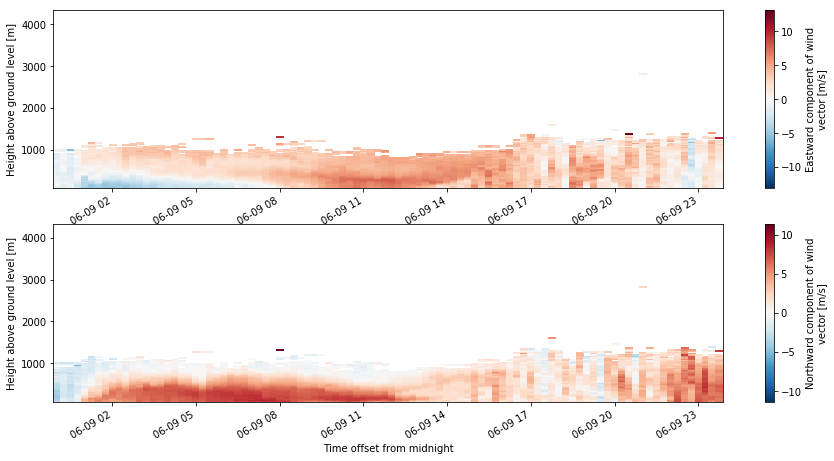

In [135]:
my_fig = plt.figure(figsize = [15,8])
spec2 = gridspec.GridSpec(ncols=1, nrows=2)
f2_ax1 = my_fig.add_subplot(spec2[0, 0])
lwd_data.u.transpose().plot.pcolormesh()

f2_ax2 = my_fig.add_subplot(spec2[1, 0])
lwd_data.v.transpose().plot.pcolormesh()



# ARSCL

In [137]:
arscl = xarray.open_dataset('../data/sgparsclkazr1kolliasC1.c0.20150609.000000.nc')

In [139]:
arscl.info()

xarray.Dataset {
dimensions:
	height = 596 ;
	layer = 10 ;
	radar_mode = 4 ;
	time = 21600 ;

variables:
	datetime64[ns] base_time() ;
		base_time:string = 2015-06-09 00:00:00 0:00 ;
		base_time:long_name = Base time in Epoch ;
		base_time:ancillary_variables = time_offset ;
	datetime64[ns] time_offset(time) ;
		time_offset:long_name = Time offset from base_time ;
		time_offset:ancillary_variables = base_time ;
	datetime64[ns] time(time) ;
		time:long_name = Time offset from midnight ;
		time:standard_name = time ;
	int32 layer(layer) ;
		layer:long_name = Cloud layer number ;
		layer:units = unitless ;
	float32 height(height) ;
		height:long_name = Height above ground level ;
		height:units = m ;
		height:standard_name = height ;
	float32 reflectivity_best_estimate(time, height) ;
		reflectivity_best_estimate:long_name = Best-estimate reflectivity ;
		reflectivity_best_estimate:units = dBZ ;
		reflectivity_best_estimate:ancillary_variables = qc_reflectivity_best_estimate ;
		reflectiv

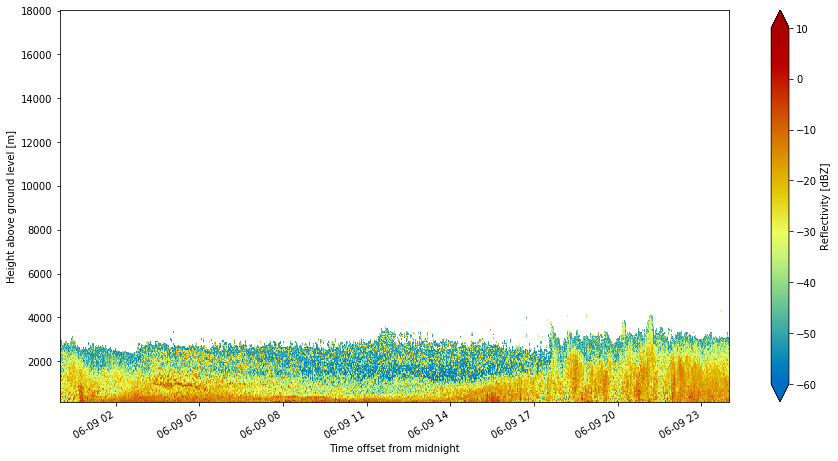

In [148]:
my_fig = plt.figure(figsize = [15,8])
arscl.reflectivity.transpose().plot.pcolormesh(vmax=10, vmin=-60, cmap=HomeyerRainbow)

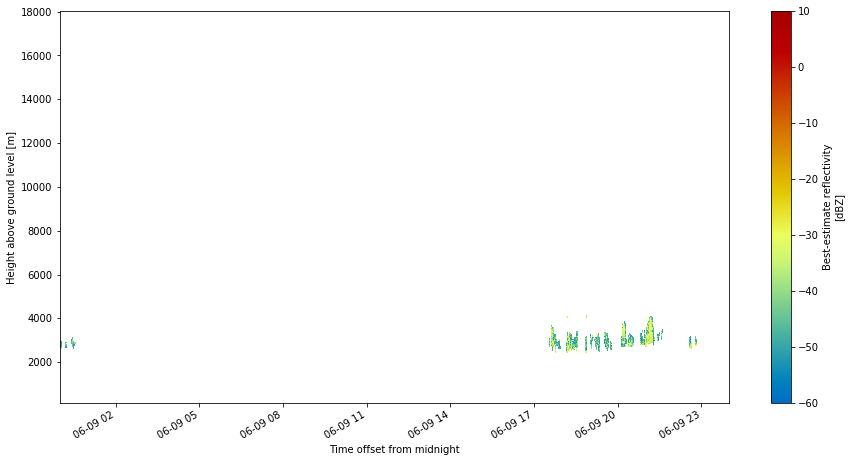

In [149]:
my_fig = plt.figure(figsize = [15,8])
arscl.reflectivity_best_estimate.transpose().plot.pcolormesh(vmax=10, vmin=-60, cmap=HomeyerRainbow)

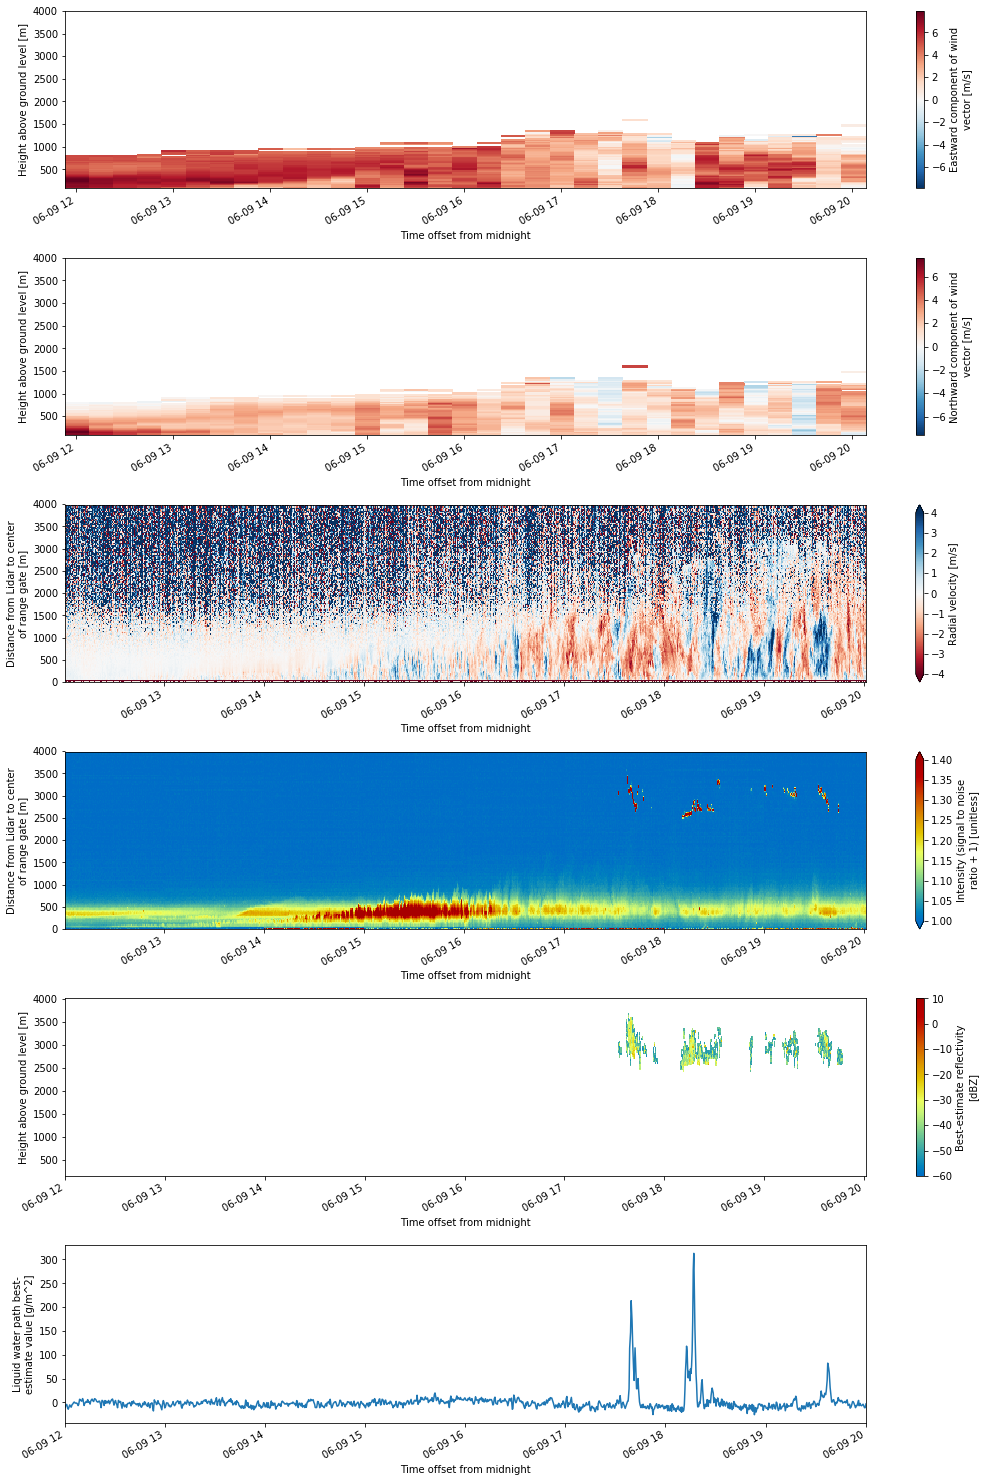

In [189]:
tbounds = slice('2015-06-09 12:00', '2015-06-09 20:00')
hbounds = slice(0.,4000.)

my_fig = plt.figure(figsize = [15,20])
spec2 = gridspec.GridSpec(ncols=1, nrows=6)
f2_ax1 = my_fig.add_subplot(spec2[0, 0])
lwd_data.u.transpose().sel(time=tbounds, height=hbounds).plot.pcolormesh()

f2_ax2 = my_fig.add_subplot(spec2[1, 0])
lwd_data.v.transpose().sel(time=tbounds, height=hbounds).plot.pcolormesh()

f2_ax3 = my_fig.add_subplot(spec2[2, 0])
dl_fpt.radial_velocity.transpose().sel(time=tbounds, range=hbounds).plot.pcolormesh(vmin=-4, vmax=4, cmap=plt.cm.RdBu)

f2_ax4 = my_fig.add_subplot(spec2[3, 0])
dl_fpt.intensity.transpose().sel(time=tbounds, range=hbounds).plot.pcolormesh(vmin=1, vmax=1.4, cmap=HomeyerRainbow)

f2_ax5 = my_fig.add_subplot(spec2[4, 0])
zplt = arscl.reflectivity_best_estimate.transpose().sel(time=tbounds, height=hbounds).plot.pcolormesh(vmax=10, vmin=-60, cmap=HomeyerRainbow)

plt.tight_layout()

f2_ax6 = my_fig.add_subplot(spec2[5, 0])
mwrret.be_lwp.sel(time=tbounds).plot()

plt.xlim(['2015-06-09 12:00', '2015-06-09 20:00'])

pos1 = f2_ax5.get_position()
pos2 = f2_ax6.get_position()
pos3 = [pos2.x0 , pos2.y0 ,  pos1.width, pos2.height] 

f2_ax6.set_position(pos3) # set a new position


